CNN for Fake News classification

# Importing general usage tools

In [41]:
pip install tqdm --upgrade

Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.43.0)


In [0]:
import keras
from keras import regularizers
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import numpy as np

# Hyperparameter Adjustment

In [0]:
# parameter adjustments for fake news
maxlen = 100
embedding_dim = 300
max_features = 50000
train_glove = True   # Turn on/off for trainnable glove

# Reading in the dataset

In [44]:
# Reading files
import re
train = pd.read_csv("/content/drive/My Drive/cmpt400/dataset/train.csv")
valid = pd.read_csv("/content/drive/My Drive/cmpt400/dataset/valid.csv")
test = pd.read_csv("/content/drive/My Drive/cmpt400/dataset/test.csv")

# train['news'] = train['news'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))
# valid['news'] = valid['news'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))
# test['news'] = test['news'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))

print("Train shape : ",train.shape)
print("Valid shape : ",valid.shape)
print("Test shape : ",test.shape)


Train shape :  (10240, 2)
Valid shape :  (1284, 2)
Test shape :  (1267, 2)


In [0]:
def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

# Data Preprocessing Helper function

##Text punct cleaning

In [0]:
import re
def clean_text(x):
  x = str(x)
  for punct in "/-":
      x = x.replace(punct, ' ')
  for punct in '&':
      x = x.replace(punct, f' {punct} ')
  for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
      x = x.replace(punct, '')
  return x


##Number cleaning

In [0]:
def clean_numbers(x):
  x = re.sub('[0-9]{5,}', '#####', x)
  x = re.sub('[0-9]{4}', '####', x)
  x = re.sub('[0-9]{3}', '###', x)
  x = re.sub('[0-9]{2}', '##', x)
  return x

##Mis-spelling cleaning

In [0]:
mispell_dict =  {'colour':'color',
          'centre':'center',
          'didnt':'did not',
          'doesnt':'does not',
          'isnt':'is not',
          'shouldnt':'should not',
          'favourite':'favorite',
          'travelling':'traveling',
          'counselling':'counseling',
          'theatre':'theater',
          'cancelled':'canceled',
          'labour':'labor',
          'organisation':'organization',
          'wwii':'world war 2',
          'citicise':'criticize',
          'instagram': 'social medium',
          'whatsapp': 'social medium',
          'snapchat': 'social medium'
          }

def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispellings, mispellings_re = _get_mispell(mispell_dict)

def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]

    return mispellings_re.sub(replace, text)

##Check for vocabulary coverage 

In [0]:
import operator 

# i: oov_word_count
# k: covered_word_count 
def check_coverage(vocab,embeddings_index):
  a = {}
  oov = {}
  covered_word_count = 0
  oov_word_count = 0
  for word in tqdm(vocab):
      try:
          a[word] = embeddings_index[word]
          covered_word_count += vocab[word]
      except:

          oov[word] = vocab[word]
          oov_word_count += vocab[word]
          pass
  print()
  print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
  print('Found embeddings for  {:.2%} of all text'.format(covered_word_count / (covered_word_count + oov_word_count)))
  sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

  return sorted_x


# Loading glove

In [50]:
#created the glove matrix
from gensim.models import KeyedVectors
filepath_news = '/content/drive/My Drive/cmpt400/dataset/GoogleNews-vectors-negative300.bin'
filepath_6b = '/content/drive/My Drive/cmpt400/dataset/glove.6B.50d.txt'
embeddings_index = KeyedVectors.load_word2vec_format(filepath_news, binary=True)
# embedding_matrix = bin_create_embedding_matrix(filepath_news,tokenizer.word_index, embedding_dim)
print(embeddings_index)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


##Preprocess all in one

In [0]:
def preprocess(dataset):
  dataset = dataset.progress_apply(lambda x: clean_text(x))
  dataset = dataset.progress_apply(lambda x: clean_numbers(x))
  dataset = dataset.progress_apply(lambda x: replace_typical_misspell(x))
  dataset = dataset.progress_apply(lambda x: x.split()).values
  to_remove = ['a','to','of','and']
  dataset = [[word for word in sentence if not word in to_remove] for sentence in tqdm(dataset)]
  
  return dataset

##Call all preprocess function to clean up the dataset

In [52]:
train['news'] = preprocess(train['news'])
valid['news'] = preprocess(valid['news'])
test['news'] = preprocess(test['news'])

100%|██████████| 1267/1267 [00:00<00:00, 278871.91it/s]


Store word occurence as dictionary for quick coverage check

In [53]:
vocab_train = build_vocab(train['news'])
vocab_valid = build_vocab(valid['news'])
vocab_test = build_vocab(test['news'])
print()
# print({k: vocab[k] for k in list(vocab)[:10]})

100%|██████████| 1267/1267 [00:00<00:00, 145410.80it/s]

## Coverage Result

In [54]:
# check for vocab coverage
oov = check_coverage(vocab_train,embeddings_index)
print()
oov = check_coverage(vocab_valid,embeddings_index)
print()
oov = check_coverage(vocab_test,embeddings_index)
print()

100%|██████████| 4555/4555 [00:00<00:00, 325541.51it/s]



Found embeddings for 96.05% of vocab
Found embeddings for  99.61% of all text


Found embeddings for 98.23% of vocab
Found embeddings for  99.59% of all text


Found embeddings for 98.11% of vocab
Found embeddings for  99.53% of all text



## Build Embadding Matrix Helper Function

In [0]:
def build_matrix(word_index, embedding_index):
  vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
  # calculate how many word will be used
  num_words = min(max_features,vocab_size)

  embedding_matrix = np.zeros((num_words, embedding_dim))
  unknown_words = []

  for word, i in word_index.items():
      if i <= max_features:
          try:
              embedding_matrix[i] = embedding_index[word]
          except KeyError:
              try:
                  embedding_matrix[i] = embedding_index[word.lower()]
              except KeyError:
                  try:
                      embedding_matrix[i] = embedding_index[word.title()]
                  except KeyError:
                      unknown_words.append(word)
  return embedding_matrix, unknown_words

# Tokenization

Initialize tokenizer

In [0]:
tokenizer = Tokenizer(num_words=max_features, filters='',lower=False)

In [57]:
# Tokenizer fitting
print(list(train['news']))
tokenizer.fit_on_texts(list(train['news']) + list(valid['news']) + list(test['news']))

[['Says', 'the', 'Annies', 'List', 'political', 'group', 'supports', 'third', 'trimester', 'abortions', 'on', 'demand'], ['When', 'did', 'the', 'decline', 'coal', 'start', 'It', 'started', 'when', 'natural', 'gas', 'took', 'off', 'that', 'started', 'begin', 'in', 'President', 'George', 'W', 'Bushs', 'administration'], ['Hillary', 'Clinton', 'agrees', 'with', 'John', 'McCain', 'by', 'voting', 'give', 'George', 'Bush', 'the', 'benefit', 'the', 'doubt', 'on', 'Iran'], ['Health', 'care', 'reform', 'legislation', 'is', 'likely', 'mandate', 'free', 'sex', 'change', 'surgeries'], ['The', 'economic', 'turnaround', 'started', 'at', 'the', 'end', 'my', 'term'], ['The', 'Chicago', 'Bears', 'have', 'had', 'more', 'starting', 'quarterbacks', 'in', 'the', 'last', '##', 'years', 'than', 'the', 'total', 'number', 'tenured', 'UW', 'faculty', 'fired', 'during', 'the', 'last', 'two', 'decades'], ['Jim', 'Dunnam', 'has', 'not', 'lived', 'in', 'the', 'district', 'he', 'represents', 'for', 'years', 'now'], 

In [58]:
glove_matrix, unknown_words_glove = build_matrix(tokenizer.word_index,embedding_index=embeddings_index)
print(unknown_words_glove)
print('credit' in embeddings_index)

['hasnt', '####json', 'wasnt', 'Kasichs', '#####json', 'Cruzs', '###json', 'Gingrichs', 'SaysPresident', 'Medicares', 'Mandels', 'Klux', 'SaysHillary', 'Marwig', 'TriMets', 'healthcaregov', 'H1N1', 'Parenthoods', 'crimecriminal', 'deficitfederal', 'Securitys', 'Rigells', 'unemployments', 'AbrahamLincoln', 'Zenzinger', 'OShaughnessy', 'Silberkraus', 'SaysBernie', 'donu####t', 'Marilinda', 'AmendmentBan', 'Jan1', 'therell', 'Medicaids', 'Obamacares', 'hewent', 'wasgovernor', 'Beachs', 'DonaldTrump', 'Renaccis', 'Amtraks', 'Ganleys', 'percentincrease', 'Kaines', 'Kloppenburgs', 'NAACPs', 'FreshFromFloridacom', 'Krakows', 'SaysMichael', 'prisonand', 'Alameel', 'shootershould', 'toldevery', 'fiscalcliff', '\u202aBernie\u202c', 'Krisemans', 'branchesof', 'SaysRand', 'Paulhas', 'subminimum', 'requirecondom', 'usein', 'riskfor', '##collecting', 'Republicancandidate', 'Aphotograph', 'Democraticcongressional', 'MorganCarroll', 'SaysPeter', 'SaysVirginia', 'RepublicanScott', 'averagein', 'yearThe

In [62]:
# tokenize text 
X_train = tokenizer.texts_to_sequences(train['news'])
X_valid = tokenizer.texts_to_sequences(valid['news'])
X_test = tokenizer.texts_to_sequences(test['news'])

# pad each news to maxlen
X_train = pad_sequences(X_train, maxlen=maxlen,padding='post',truncating='post')
X_valid = pad_sequences(X_valid, maxlen=maxlen,padding='post',truncating='post')
X_test = pad_sequences(X_test, maxlen=maxlen,padding='post',truncating='post')

y_label_dict = {"pants-fire" : 0, "false" : 1, "barely-true" : 2, "half-true" : 3, "mostly-true" : 4, "true" : 5}
print(y_label_dict)

# turn categories into integer representation
y_train = train['label'].apply(lambda x: y_label_dict[x])
y_valid = valid['label'].apply(lambda x: y_label_dict[x])
y_test = test['label'].apply(lambda x: y_label_dict[x])

y_train = keras.utils.to_categorical(y_train, num_classes=6)
y_valid = keras.utils.to_categorical(y_valid, num_classes=6)
y_test = keras.utils.to_categorical(y_test, num_classes=6)

#calculate the total vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

n_timesteps, n_features = X_train.shape[0], X_train.shape[1]
print(y_train[0])
print(y_test[1])

{'pants-fire': 0, 'false': 1, 'barely-true': 2, 'half-true': 3, 'mostly-true': 4, 'true': 5}
[0. 1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0.]


# Plotting Graph Helper Function

In [0]:
# Plotting graph from results
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

# Creating Model


In [70]:
from keras.models import Sequential
from keras import layers,optimizers
from keras.layers import Conv1D,MaxPooling1D,Flatten,Dense
from keras.optimizers import Adam,SGD
from keras.losses import categorical_crossentropy
from keras.losses import sparse_categorical_crossentropy
from keras.callbacks import ModelCheckpoint

train_glove = False
sgd = optimizers.SGD(lr=0.025, clipvalue=0.3, nesterov=True)
adam = optimizers.Adam(lr=0.000075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim,weights=[glove_matrix], input_length=maxlen,trainable=train_glove))

model.add(layers.Conv1D(filters=128,kernel_size= 2, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(layers.Conv1D(filters=128,kernel_size= 3, activation='relu'))
model.add(layers.Conv1D(filters=128,kernel_size= 4, activation='relu'))
model.add(layers.GlobalMaxPool1D())             # Maybe try concatenate layers by using max and avg
# Averagepooling is easy to get stuck, find local min right away
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))
# model.compile(optimizer=sgd,loss=sparse_categorical_crossentropy,metrics=['accuracy'],)     # 0.001 seems to give the best output
# model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['categorical_accuracy'])
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

cp=ModelCheckpoint('model_fake',monitor='val_categorical_accuracy',verbose=1, save_best_only=True, mode='max')

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 300)          4464900   
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 99, 128)           76928     
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 97, 128)           49280     
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 94, 128)           65664     
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 128)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 6)               

# Predicting


Train on 10240 samples, validate on 1284 samples
Epoch 1/10
10240/10240 [==============================] - 2s 165us/step - loss: 1.7762 - acc: 0.1898 - val_loss: 1.7608 - val_acc: 0.1947
Epoch 2/10
 1856/10240 [====>.........................] - ETA: 0s - loss: 1.7597 - acc: 0.2101

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:707: RuntimeWarning: Can save best model only with val_categorical_accuracy available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


10240/10240 [==============================] - 1s 91us/step - loss: 1.7588 - acc: 0.2062 - val_loss: 1.7630 - val_acc: 0.2204
Epoch 3/10
10240/10240 [==============================] - 1s 92us/step - loss: 1.7546 - acc: 0.2098 - val_loss: 1.7576 - val_acc: 0.2227
Epoch 4/10
10240/10240 [==============================] - 1s 93us/step - loss: 1.7500 - acc: 0.2182 - val_loss: 1.7564 - val_acc: 0.2033
Epoch 5/10
10240/10240 [==============================] - 1s 91us/step - loss: 1.7458 - acc: 0.2266 - val_loss: 1.7550 - val_acc: 0.2188
Epoch 6/10
10240/10240 [==============================] - 1s 91us/step - loss: 1.7436 - acc: 0.2321 - val_loss: 1.7532 - val_acc: 0.2266
Epoch 7/10
10240/10240 [==============================] - 1s 90us/step - loss: 1.7368 - acc: 0.2447 - val_loss: 1.7496 - val_acc: 0.2414
Epoch 8/10
10240/10240 [==============================] - 1s 91us/step - loss: 1.7330 - acc: 0.2487 - val_loss: 1.7490 - val_acc: 0.2251
Epoch 9/10
10240/10240 [============================

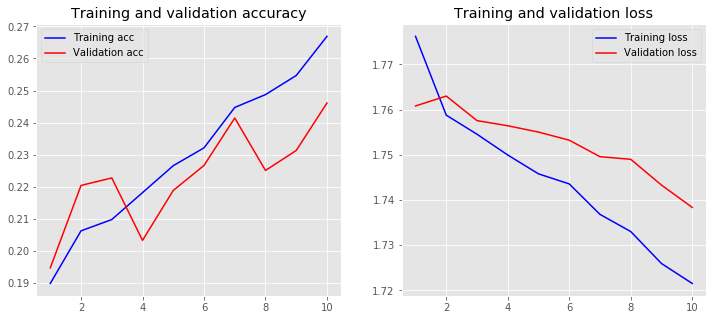

In [71]:
history = model.fit(X_train, y_train, epochs=10, verbose=1, validation_data=(X_valid, y_valid),batch_size=64,callbacks=[cp])
loss, accuracy = model.evaluate(X_valid, y_valid, verbose=2)
print("Valid Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)